Predicting UP IR flux on all layers, using all the layers now

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest hieght to highest hieght

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
d_c2 = DS_w.TAU_OD2D.values
d_c2.shape

(71, 36, 72)

In [8]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [9]:
uif = DS_a.UPIRFLUX.values[1:,:,:,:] #look at up visual flux on 10th layer
uif[:,1,:,:].reshape(-1).shape

(181440,)

In [10]:
uif[:,1,:,:].shape

(70, 36, 72)

In [11]:
temp_uif = []
for i in range(52):
    temp_uif.append(uif[:,i,:,:].reshape(-1))
uif = np.array(temp_uif).T
uif.shape

(181440, 52)

In [12]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52): #using all the layers now
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [13]:
sla.shape

(181440, 53)

# Trying linear regression first

In [14]:
from sklearn.linear_model import LinearRegression
uif_out = uif
lr1 = LinearRegression()
lr1.fit(sla,uif_out)
uif_lin = lr1.predict(sla) #predicted

In [15]:
lr1.coef_

array([[ 3.2619688e-08,  3.9561286e-08, -2.1152733e-08, ...,
         5.8138383e-09, -5.0953952e-09,  3.2038514e-09],
       [ 3.2619699e-08,  3.9561161e-08, -2.1152697e-08, ...,
         5.8140515e-09, -5.0956483e-09,  3.2035103e-09],
       [ 3.2619713e-08,  3.9561034e-08, -2.1152633e-08, ...,
         5.8141509e-09, -5.0958642e-09,  3.2031977e-09],
       ...,
       [ 4.0894953e-08,  2.5016998e-08, -9.1155918e-09, ...,
         1.4005039e-08, -1.1064600e-08,  7.2029849e-09],
       [ 4.1195946e-08,  2.5418810e-08, -9.1853121e-09, ...,
         1.4139502e-08, -1.1177558e-08,  7.4946058e-09],
       [ 4.1598369e-08,  2.6165194e-08, -8.9638199e-09, ...,
         1.4301541e-08, -1.1325945e-08,  7.8907476e-09]], dtype=float32)

In [16]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.3685

In [17]:
np.min(uif_out)

15.631578

In [18]:
np.max(uif_out)

484.69852

In [19]:
uif_diff = (uif_out - uif_lin).reshape(-1)

In [20]:
np.min(uif_diff)

-41.411087

In [21]:
np.max(uif_diff)

100.696075

In [22]:
uif_diff.shape

(9434880,)

In [23]:
np.where(uif_diff > 50)

(array([ 213876,  213877,  213878, ..., 9379237, 9379238, 9379239],
       dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

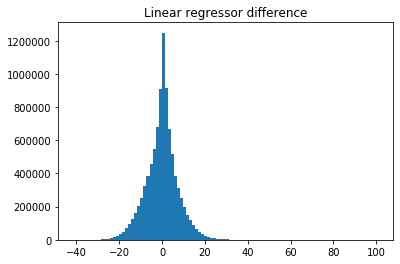

In [24]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [25]:
uif_out.reshape(-1,1).shape

(9434880, 1)

In [26]:
uif_lin[:,1].shape

(181440,)

In [27]:
sla[:10*36*72,:].shape

(25920, 53)

In [28]:
sla[10*36*72:11*36*72,:].shape

(2592, 53)

In [29]:
real_out = uif_out[10*36*72:11*36*72, 10].reshape(36,72) #let's plot 10th layer
pred_out = uif_lin[10*36*72:11*36*72, 10].reshape(36,72)

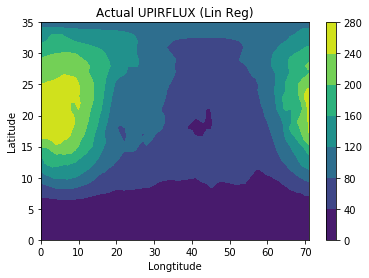

In [30]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

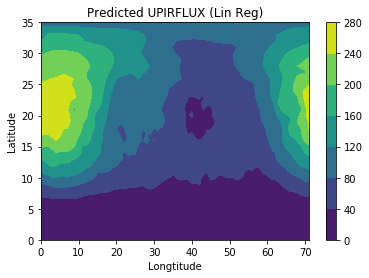

In [31]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

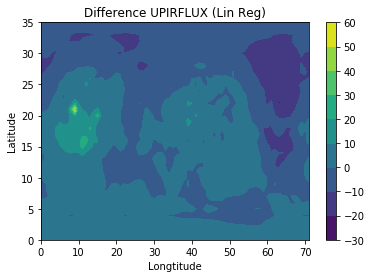

In [32]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

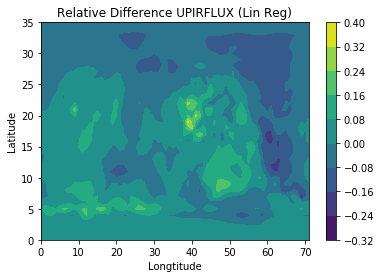

In [33]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [34]:
uif_out[:10*36*72].shape

(25920, 52)

# Let's try random forest regressor:

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rfr1 = RandomForestRegressor()
rfr1.fit(sla[:10*36*72],uif_out[:10*36*72]) #training set
uif_rfr = rfr1.predict(sla[10*36*72:11*36*72]) 

rfr_mse = mean_squared_error(uif_out[10*36*72:11*36*72], uif_rfr) #test the model on a single day
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2.409584744825955

In [36]:
sla[:10*36*72,:].shape

(25920, 53)

In [37]:
rfr_diff = (uif_out[10*36*72:11*36*72] - uif_rfr).reshape(-1)

In [38]:
rfr_diff.shape

(134784,)

<function matplotlib.pyplot.show(*args, **kw)>

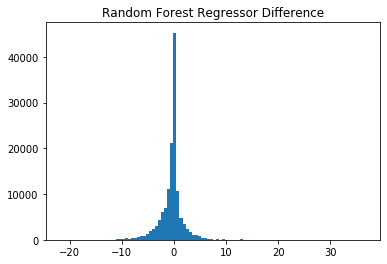

In [39]:
plt.hist(rfr_diff, bins = 100)
plt.title("Random Forest Regressor Difference")
plt.show #wow, much better!

In [40]:
real_out = uif_out[10*36*72:11*36*72, 10].reshape(36,72) #let's plot 10th layer
pred_out = uif_rfr[:,10].reshape(36,72)

In [41]:
np.max(uif_out[10*36*72:11*36*72])

325.08307

In [42]:
np.array_equal(uif_rfr[:,10],pred_out.reshape(-1))

True

In [43]:
real_out.shape

(36, 72)

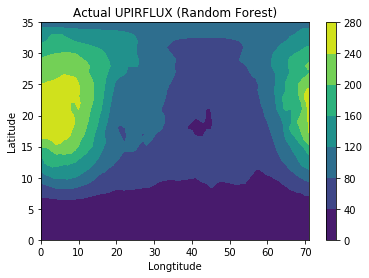

In [44]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

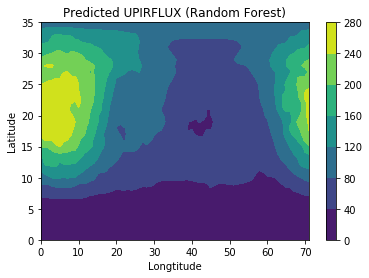

In [45]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

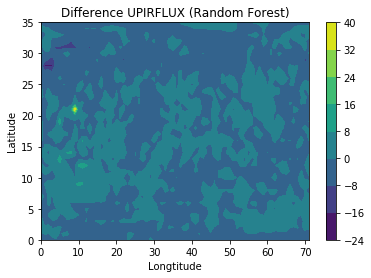

In [46]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

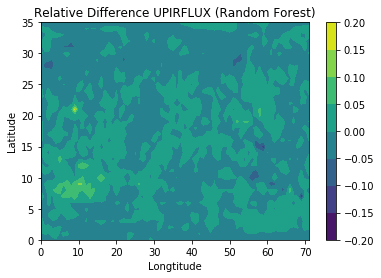

In [47]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [48]:
uif_rfr[:,10].shape

(2592,)

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [49]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [50]:
real_out.shape

(36, 72)

Integrals for 10th layer:

In [51]:
rfr_int_err = int_err(uif_rfr[:,10], uif_out[10*36*72:11*36*72,10], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Random forest integration error:")
rfr_int_err/(1.44e14) #smaller!

Random forest integration error:


-0.3388698589834402

In [52]:
lin_int_err = int_err(uif_lin[10*36*72:11*36*72,10], uif_out[10*36*72:11*36*72,10], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Linear regression integration error:")
lin_int_err/(1.44e14) #also smaller than when just using the 10 layers

Linear regression integration error:


-0.6345342010345507

Integrals for all layers:

In [53]:
rfr_t_int = [] #total rfr integral list
for i in range(52):
    rfr_int_err = int_err(uif_rfr[:,i], uif_out[10*36*72:11*36*72,i], pd.DataFrame(uif_rfr), 3.39e6) 
    rfr_t_int.append(rfr_int_err/1.44e14) 
    
lin_t_int = [] #total lin integral list
for i in range(52):
    lin_int_err = int_err(uif_lin[10*36*72:11*36*72,i], uif_out[10*36*72:11*36*72,i], pd.DataFrame(uif_rfr), 3.39e6) 
    lin_t_int.append(lin_int_err/1.44e14) 


In [54]:
np.array(rfr_t_int) #errors from random forest regressor for all layers

array([-0.33804666, -0.3380511 , -0.33805346, -0.33804815, -0.33815586,
       -0.33856769, -0.33864298, -0.3384551 , -0.3385276 , -0.33879683,
       -0.33886986, -0.33860814, -0.33846729, -0.33867719, -0.3391084 ,
       -0.33951043, -0.33988731, -0.3406623 , -0.34218431, -0.34460176,
       -0.34749447, -0.34956757, -0.34860066, -0.34375043, -0.33677913,
       -0.32856952, -0.32018573, -0.31195421, -0.3042489 , -0.29605726,
       -0.28945422, -0.28696871, -0.28945944, -0.29128772, -0.28913021,
       -0.28079194, -0.26709006, -0.25722051, -0.25452302, -0.25615793,
       -0.25975228, -0.26252519, -0.26565672, -0.26929573, -0.27327399,
       -0.27580692, -0.27844091, -0.28153035, -0.28456006, -0.28667596,
       -0.28876617, -0.29165322])

In [55]:
np.array(lin_t_int) #errors from linear regressor for all layers

array([-0.63507658, -0.63523188, -0.63510231, -0.63502404, -0.63521518,
       -0.63506335, -0.63499462, -0.63503287, -0.6348302 , -0.6346854 ,
       -0.6345342 , -0.63415755, -0.63361612, -0.6330808 , -0.63320287,
       -0.63399444, -0.63535434, -0.63796532, -0.64234833, -0.64933458,
       -0.65985347, -0.67367199, -0.68735466, -0.69741586, -0.70232307,
       -0.7010847 , -0.69516762, -0.68832358, -0.67903912, -0.66713983,
       -0.65493802, -0.64800978, -0.64246818, -0.63651476, -0.6289336 ,
       -0.61514834, -0.59976053, -0.59142325, -0.59110369, -0.59367857,
       -0.5984468 , -0.60201052, -0.60636821, -0.61201869, -0.61944073,
       -0.62572257, -0.63331737, -0.64299806, -0.65569565, -0.6723901 ,
       -0.69344313, -0.72259636])

All the errors have the same sign...Let's look at the averages:

In [56]:
print("Rfr average:")
print(np.average(np.array(rfr_t_int)))
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Rfr average:
-0.3105990678646947
Lin reg average:
-0.6433778038465549
